## Toxic Comment Classification Challenge

### Introduction
This project aims to classify online comments into various toxicity categories such as toxic, severe toxic, obscene, threat, insult, and identity hate.

### Data Loading and Initial Exploration

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [11]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

### Data Preprocessing
Here, we convert the raw comments into a matrix of TF-IDF features. We also define a custom tokenizer to handle punctuations and special characters effectively.

In [12]:
import re, string

def tokenize(s):
    re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
    return re_tok.sub(r' \1 ', s).split()


In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X = vectorizer.fit_transform(train['comment_text'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Model Training and Evaluation
For each toxicity label, we train multiple models including Logistic Regression, Naive Bayes, and Support Vector Machine. We then evaluate each model's performance using the ROC curve.

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


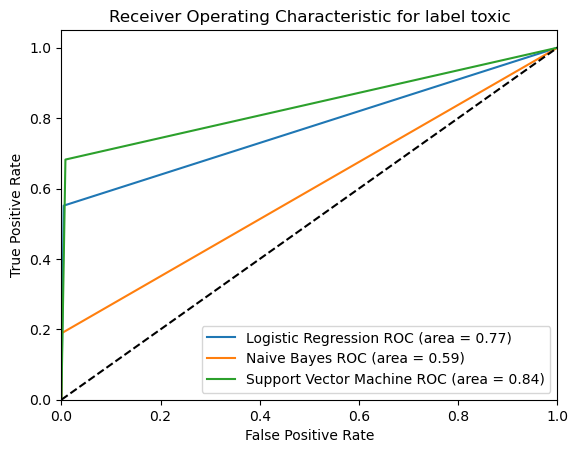

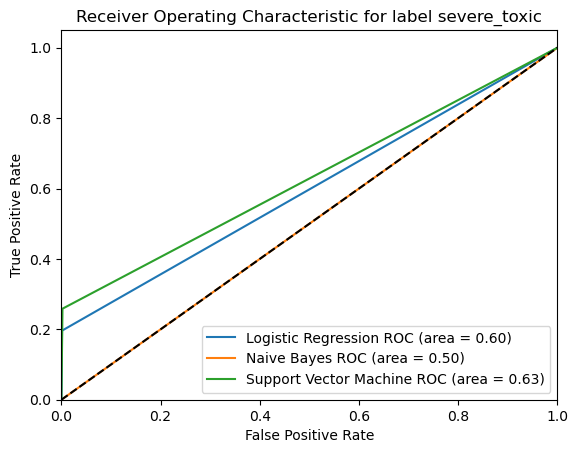

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


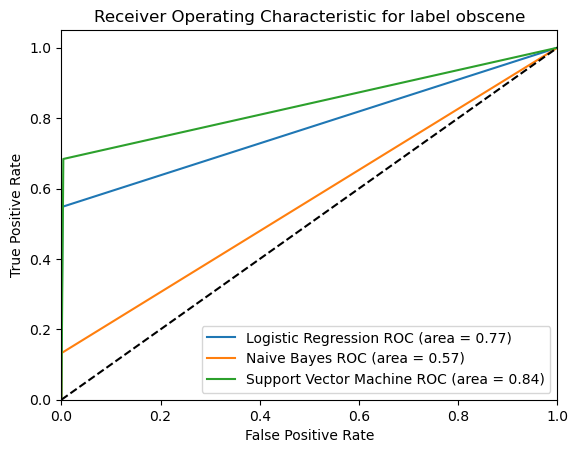

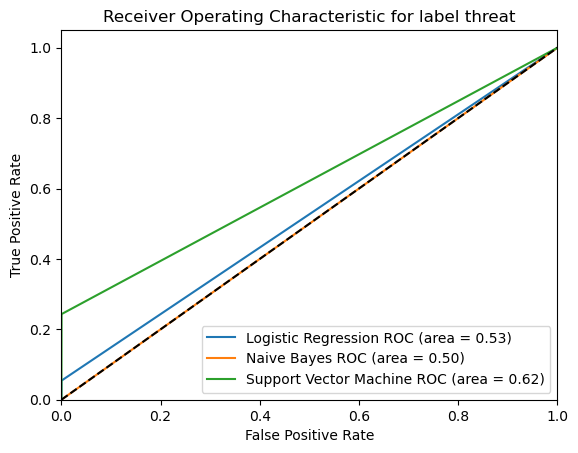

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


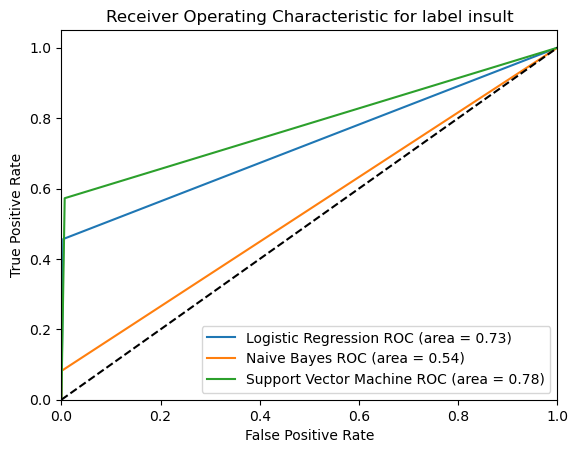

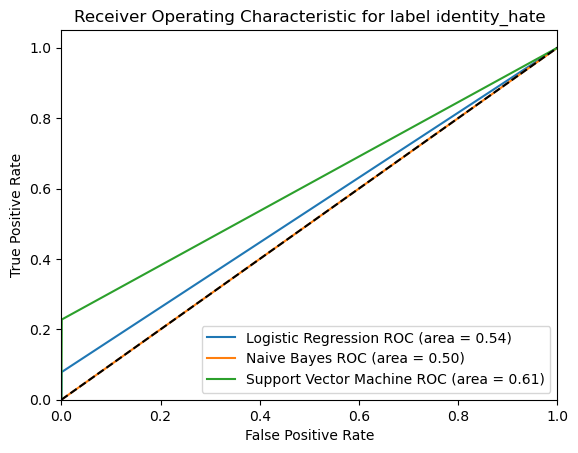

In [14]:
# Labels to be predicted
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# For each label, predict using trained models
for label in label_cols:
    y = train[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    models = [
        ('Logistic Regression', LogisticRegression()),
        ('Naive Bayes', MultinomialNB()),
        ('Support Vector Machine', LinearSVC())
    ]

    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for label %s' % label)
    plt.legend(loc="lower right")
    plt.show()


### Prediction and Submission
Finally, we predict the toxicity probabilities for the test set and save the results for Kaggle submission.

In [15]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

# Read the decompressed CSV file
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

# Convert the text in the test dataset to TF-IDF features
X_test = vectorizer.transform(test['comment_text'])

# Labels to be predicted
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create an empty DataFrame to store your prediction results
submission = pd.DataFrame()
# Add 'id' to the submission file
submission['id'] = test['id']
# For each label, predict using trained models
for label in label_cols:
    y = train[label]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = CalibratedClassifierCV(LinearSVC())
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]  # Get the prediction probability for the positive class
    submission[label] = y_pred

# Save the results as a CSV file, which you can upload to Kaggle
submission.to_csv('submission.csv', index=False)
